# Southern California Edison (SCE) Load Forecasting 

##  Description:

### 1. Performed preliminary analysis of data and created new features by the trend and  seasonality of continuous data.

### 2. Forecasted electricity consumption load for future 16 hours using Linear Regression, Lasso Regression and Ridge Regression.

### 3. Validated models by K-fold cross validation and performed model evaluation using MAE and MAPE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import datetime
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [2]:
df = pd.read_excel('forecasting.xlsx', sheet_name = 'Sheet1')

In [3]:
df.head()

,Date,Load,temp
0,2014-01-01 00:00:00,9891.0,59.4685
1,2014-01-01 01:00:00,9553.0,61.4030
2,2014-01-01 02:00:00,9222.0,55.0310
3,2014-01-01 03:00:00,9024.0,53.1878
4,2014-01-01 04:00:00,8987.0,51.9944


In [4]:
# create features
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['datehour'] = df['Date'].dt.hour
df['temp2'] = df['temp']**2

#### add new feature: split days into weekday and weekend

In [5]:
df['day of week'] = df['Date'].dt.dayofweek
df['weekday & weekend'] = np.nan
df.loc[(df['day of week'] >=0) & (df['day of week'] <= 4),'weekday & weekend'] = '1'  # weekday is 1
df.loc[(df['day of week'] >=5) & (df['day of week'] <= 6),'weekday & weekend'] = '2'  # weekend is 2


Text(0, 0.5, 'Monthly Load for weekday and weekend')

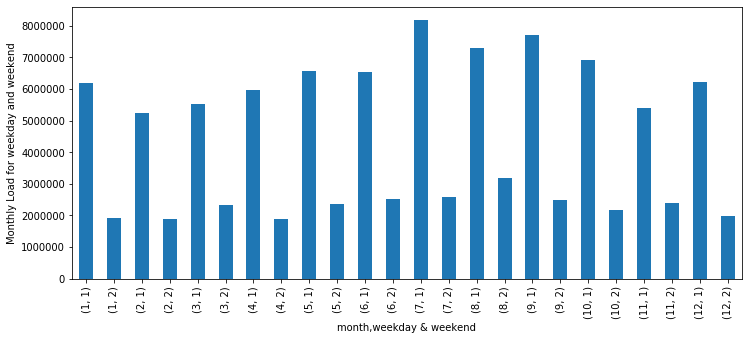

In [6]:
# sample check:
year_2014 = df.loc[df['year'] == 2014]
dd_2014 = year_2014.groupby(['month','weekday & weekend'])['Load'].sum()
dd_2014.plot(kind = 'bar', figsize = (12,5) )
plt.ylabel('Monthly Load for weekday and weekend')
# weekday is 1, weekend is 2
# Loads on weekdays are much larger than weekends

In [7]:
df.set_index('Date',inplace = True)
df.head()

,Load,temp,year,month,day,datehour,temp2,day of week,weekday & weekend
Date,,,,,,,,,
2014-01-01 00:00:00,9891.0,59.4685,2014,1,1,0,3536.502492,2,1
2014-01-01 01:00:00,9553.0,61.4030,2014,1,1,1,3770.328409,2,1
2014-01-01 02:00:00,9222.0,55.0310,2014,1,1,2,3028.410961,2,1
2014-01-01 03:00:00,9024.0,53.1878,2014,1,1,3,2828.942069,2,1
2014-01-01 04:00:00,8987.0,51.9944,2014,1,1,4,2703.417631,2,1


Text(0, 0.5, 'Load')

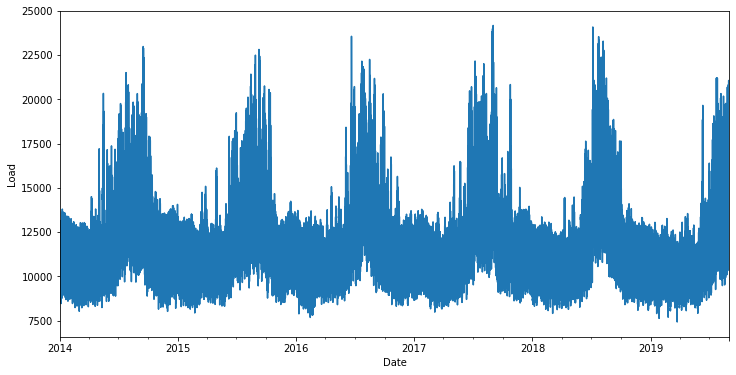

In [8]:
# relationship between date and Load
df['Load'].plot(figsize = (12,6))      # Load has similar trend by year
plt.ylabel('Load')

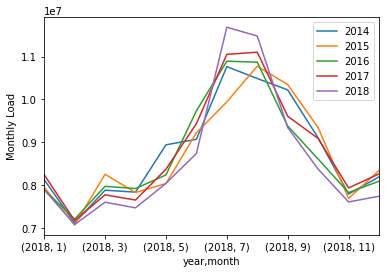

In [9]:
mm = df.groupby(['year','month'])['Load'].sum()
year = ['2014','2015','2016','2017','2018']
for j in year:
    mm.loc[int(j),:].plot()
plt.legend(year)
plt.ylabel('Monthly Load')
plt.show()
# In each year, Load has seasonarity

#### add quarter feature

In [10]:
df['quarter'] = np.nan
df.loc[(df['month'] >=1) & (df['month'] <= 3),'quarter'] = '1'     # first quarter is 1
df.loc[(df['month'] >=4) & (df['month'] <= 6),'quarter'] = '2'     # second quarter is 2
df.loc[(df['month'] >=7) & (df['month'] <= 9),'quarter'] = '3'     # third quarter is 3
df.loc[(df['month'] >=10) & (df['month'] <= 12),'quarter'] = '4'   # fourth quarter is 4

#### new feature: split hour into several period by weekday & weekend

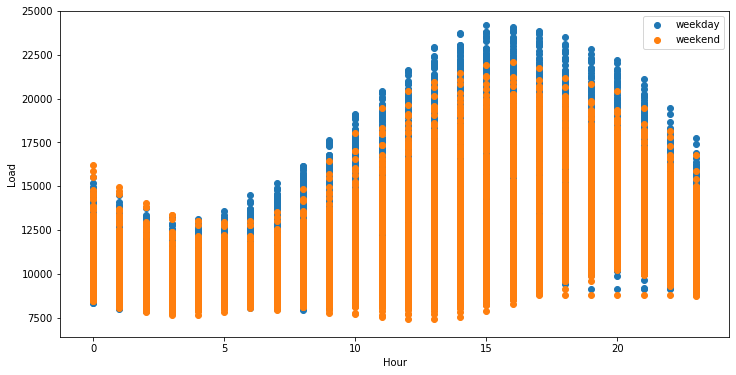

In [11]:
# plot relationship between Load and weekday&weekend
t1 = df.loc[df['weekday & weekend'] == '1']
xx = t1['datehour']
yy = t1['Load']
t2 = df.loc[df['weekday & weekend'] == '2']
xx1 = t2['datehour']
yy1 = t2['Load']

plt.figure(figsize = (12,6))
plt.scatter(xx,yy)
plt.scatter(xx1,yy1)
plt.legend(['weekday','weekend'])
plt.ylabel('Load')
plt.xlabel('Hour')
plt.show()


In [12]:
df['week & period'] = np.nan
df.loc[(df['datehour'] >= 0) & (df['datehour'] <= 1) & (df['weekday & weekend'] == '1'),'week & period'] = 'weekday late night' 
df.loc[(df['datehour'] > 21) & (df['datehour'] <= 23) & (df['weekday & weekend'] == '1'),'week & period'] = 'weekday late night' 
df.loc[(df['datehour'] > 1) & (df['datehour'] <= 6) & (df['weekday & weekend'] == '1'),'week & period'] = ' weekday midnight'     
df.loc[(df['datehour'] > 6) & (df['datehour'] <= 9) & (df['weekday & weekend'] == '1'),'week & period'] = 'weekday early morning' 
df.loc[(df['datehour'] > 9) & (df['datehour'] <= 11) & (df['weekday & weekend'] == '1'),'week & period'] = 'weekday morning' 
df.loc[(df['datehour'] > 11) & (df['datehour'] <= 17) & (df['weekday & weekend'] == '1'),'week & period'] = 'weekday noon & afternoon' 
df.loc[(df['datehour'] > 17) & (df['datehour'] <= 21) & (df['weekday & weekend'] == '1'),'week & period'] = 'weekday night' 

df.loc[(df['datehour'] >= 0) & (df['datehour'] <= 1) & (df['weekday & weekend'] == '2'),'week & period'] = 'weekend late night' 
df.loc[(df['datehour'] > 21) & (df['datehour'] <= 23) & (df['weekday & weekend'] == '2'),'week & period'] = 'weekend late night' 
df.loc[(df['datehour'] > 1) & (df['datehour'] <= 6) & (df['weekday & weekend'] == '2'),'week & period'] = ' weekend midnight'     
df.loc[(df['datehour'] > 6) & (df['datehour'] <= 9) & (df['weekday & weekend'] == '2'),'week & period'] = 'weekend early morning' 
df.loc[(df['datehour'] > 9) & (df['datehour'] <= 11) & (df['weekday & weekend'] == '2'),'week & period'] = 'weekend morning' 
df.loc[(df['datehour'] > 11) & (df['datehour'] <= 17) & (df['weekday & weekend'] == '2'),'week & period'] = 'weekend noon & afternoon' 
df.loc[(df['datehour'] > 17) & (df['datehour'] <= 21) & (df['weekday & weekend'] == '2'),'week & period'] = 'weekend night' 
df.head()

,Load,temp,year,month,day,datehour,temp2,day of week,weekday & weekend,quarter,week & period
Date,,,,,,,,,,,
2014-01-01 00:00:00,9891.0,59.4685,2014,1,1,0,3536.502492,2,1,1,weekday late night
2014-01-01 01:00:00,9553.0,61.4030,2014,1,1,1,3770.328409,2,1,1,weekday late night
2014-01-01 02:00:00,9222.0,55.0310,2014,1,1,2,3028.410961,2,1,1,weekday midnight
2014-01-01 03:00:00,9024.0,53.1878,2014,1,1,3,2828.942069,2,1,1,weekday midnight
2014-01-01 04:00:00,8987.0,51.9944,2014,1,1,4,2703.417631,2,1,1,weekday midnight


#### view peak time load

In [13]:
mh_mean = df.groupby(['month','datehour']).mean() 
mh = mh_mean['Load']
mh_list = []
for i in range(1,13):
    for j in range(0,24):
        x = mh[i][j]
        mh_list.append(x)
number = np.array(mh_list).reshape(-1,1)
month_list = []
hour_list = np.asarray(list(range(0,24))*12).reshape(-1,1)
for i in range(1,13):
        it = [i]*24
        month_list.append(it)
month_list =  np.asarray(month_list).reshape(-1,1)
month_hour = pd.DataFrame(number, columns = ['Load'])
month_hour['M'] = month_list
month_hour['H'] = hour_list
month_hour = month_hour.sort_values(by = 'Load')

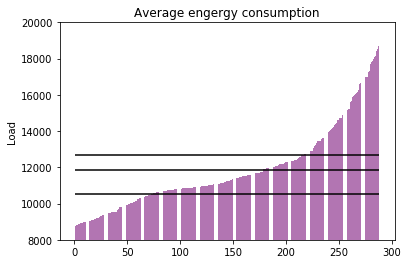

In [14]:
q1 = np.quantile(month_hour['Load'], .25)
q2 = np.quantile(month_hour['Load'], .50)
q3 = np.quantile(month_hour['Load'], .75)
plt.bar(list(range(1,289)),month_hour['Load'], color = (0.5,0.1,0.5,0.6))
plt.title('Average engergy consumption')
plt.ylabel('Load')
plt.ylim(8000,20000)
plt.hlines(month_hour.mean(),xmin = 1, xmax = 288)
plt.hlines(q1,xmin = 1, xmax = 288)
plt.hlines(q3,xmin = 1, xmax = 288)
plt.show()

### how temperature effect the energy consumption?  

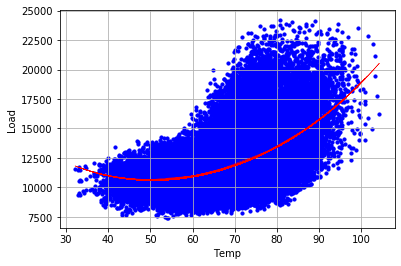

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
poly = df['temp'].values.reshape(-1,1)
poly_model = PolynomialFeatures(degree=4)
poly2 = poly_model.fit_transform(poly)
model = LinearRegression().fit(poly2,df['Load'])
yhat   = model.predict(poly2)
plt.scatter(df['temp'],df['Load'],c='b',s=10)
plt.plot(df['temp'],yhat,c='r',lw=0.5)
plt.xlabel('Temp')
plt.ylabel('Load')
plt.grid()

### temp and hour
#### 1. create two new features: multiply temp by hour, multiply square of temp by hour 

In [16]:
df['temp & hour'] = df['temp']* df['datehour']
df['temp2 & hour'] = df['temp2']* df['datehour']

Text(0.5, 0, 'Hour')

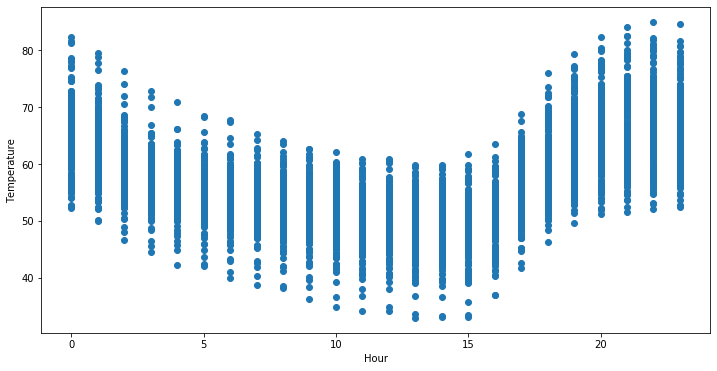

In [17]:
# sample check: In January, relationship between temp and hour
t3 = df.loc[df['month'] == 1]
xxx = t3['datehour']
yyy = t3['temp']
plt.figure(figsize = (12,6))
plt.scatter(xxx,yyy)
plt.ylabel('Temperature')
plt.xlabel('Hour')


#### 2. split hour into period by temperature

In [18]:
df['temp_h'] = np.nan 
df.loc[(df['datehour'] >3) & (df['datehour'] <= 9),'temp_h'] = 'temp1'     
df.loc[(df['datehour'] >9) & (df['datehour'] <= 17),'temp_h'] = 'temp2'     
df.loc[(df['datehour'] >17) & (df['datehour'] <= 23),'temp_h'] = 'temp3'
df.loc[(df['datehour'] >=0) & (df['datehour'] <= 3),'temp_h'] = 'temp3'
df.head()

,Load,temp,year,month,day,datehour,temp2,day of week,weekday & weekend,quarter,week & period,temp & hour,temp2 & hour,temp_h
Date,,,,,,,,,,,,,,
2014-01-01 00:00:00,9891.0,59.4685,2014,1,1,0,3536.502492,2,1,1,weekday late night,0.0000,0.000000,temp3
2014-01-01 01:00:00,9553.0,61.4030,2014,1,1,1,3770.328409,2,1,1,weekday late night,61.4030,3770.328409,temp3
2014-01-01 02:00:00,9222.0,55.0310,2014,1,1,2,3028.410961,2,1,1,weekday midnight,110.0620,6056.821922,temp3
2014-01-01 03:00:00,9024.0,53.1878,2014,1,1,3,2828.942069,2,1,1,weekday midnight,159.5634,8486.826207,temp3
2014-01-01 04:00:00,8987.0,51.9944,2014,1,1,4,2703.417631,2,1,1,weekday midnight,207.9776,10813.670525,temp1


In [19]:
# temp_mean = []
# for i in range(1,13):
#     avg = df.loc[df['month'] == i]['temp'].mean()
#     temp_mean.append(df.loc[df['month'] == i]['temp'].mean())
# temp_mean

### temp and month
#### 1. add new feature: multiply temp by month; multiply square of temp by month

In [20]:
df['temp & month'] = df['temp'] * df['month']
df['temp2 & month'] = df['temp2'] * df['month']

Text(0.5, 1.0, 'April')

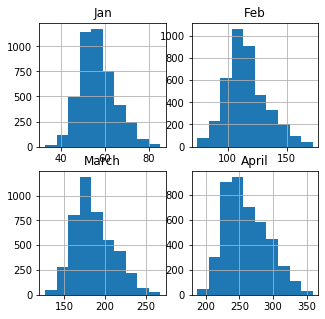

In [21]:
# distribution of temp & month 
plt.subplot(221)
df.loc[df['month'] == 1]['temp & month'].hist(figsize = (5,5))
plt.title('Jan')
plt.subplot(222)
df.loc[df['month'] == 2]['temp & month'].hist(figsize = (5,5))
plt.title('Feb')
plt.subplot(223)
df.loc[df['month'] == 3]['temp & month'].hist(figsize = (5,5))
plt.title('March')
plt.subplot(224)
df.loc[df['month'] == 4]['temp & month'].hist(figsize = (5,5))
plt.title('April')

Text(0.5, 1.0, 'Aug')

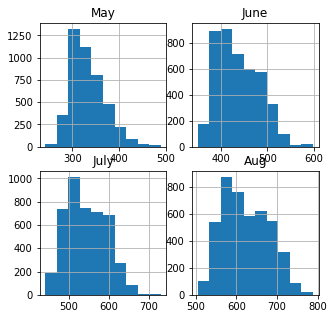

In [22]:
plt.subplot(221)
df.loc[df['month'] == 5]['temp & month'].hist(figsize = (5,5))
plt.title('May')
plt.subplot(222)
df.loc[df['month'] == 6]['temp & month'].hist(figsize = (5,5))
plt.title('June')
plt.subplot(223)
df.loc[df['month'] == 7]['temp & month'].hist(figsize = (5,5))
plt.title('July')
plt.subplot(224)
df.loc[df['month'] == 8]['temp & month'].hist(figsize = (5,5))
plt.title('Aug')

Text(0.5, 1.0, 'Dec')

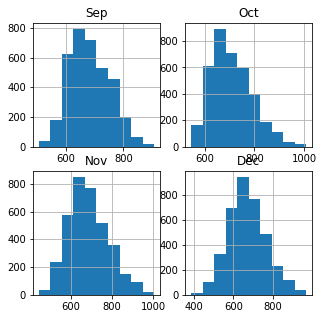

In [23]:
plt.subplot(221)
df.loc[df['month'] == 9]['temp & month'].hist(figsize = (5,5))
plt.title('Sep')
plt.subplot(222)
df.loc[df['month'] == 10]['temp & month'].hist(figsize = (5,5))
plt.title('Oct')
plt.subplot(223)
df.loc[df['month'] == 11]['temp & month'].hist(figsize = (5,5))
plt.title('Nov')
plt.subplot(224)
df.loc[df['month'] == 12]['temp & month'].hist(figsize = (5,5))
plt.title('Dec')

#### 2. new feature: split temp&month into several range based on above hist graph

In [24]:
df['temp_m'] = np.nan
df.loc[df['temp & month'] <= 80,'temp_m'] = '1'     
df.loc[(df['temp & month'] >80) & (df['temp & month'] <= 140),'temp_m'] = '2'     
df.loc[(df['temp & month'] >140) & (df['temp & month'] <= 220),'temp_m'] = '3'     
df.loc[(df['temp & month'] >220) & (df['temp & month'] <= 370),'temp_m'] = '5'
df.loc[(df['temp & month'] >370) & (df['temp & month'] <= 480),'temp_m'] = '6'
df.loc[(df['temp & month'] >480) & (df['temp & month'] <= 570),'temp_m'] = '7'
df.loc[(df['temp & month'] >570) & (df['temp & month'] <= 600),'temp_m'] = '8'
df.loc[df['temp & month'] >600, 'temp_m'] = 'other'

df.head()

,Load,temp,year,month,day,datehour,temp2,day of week,weekday & weekend,quarter,week & period,temp & hour,temp2 & hour,temp_h,temp & month,temp2 & month,temp_m
Date,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9891.0,59.4685,2014,1,1,0,3536.502492,2,1,1,weekday late night,0.0000,0.000000,temp3,59.4685,3536.502492,1
2014-01-01 01:00:00,9553.0,61.4030,2014,1,1,1,3770.328409,2,1,1,weekday late night,61.4030,3770.328409,temp3,61.4030,3770.328409,1
2014-01-01 02:00:00,9222.0,55.0310,2014,1,1,2,3028.410961,2,1,1,weekday midnight,110.0620,6056.821922,temp3,55.0310,3028.410961,1
2014-01-01 03:00:00,9024.0,53.1878,2014,1,1,3,2828.942069,2,1,1,weekday midnight,159.5634,8486.826207,temp3,53.1878,2828.942069,1
2014-01-01 04:00:00,8987.0,51.9944,2014,1,1,4,2703.417631,2,1,1,weekday midnight,207.9776,10813.670525,temp1,51.9944,2703.417631,1


#### 3. temp classification

In [25]:
# add feature: monthly temp classification
name = {'temp_jan':1,'temp_feb':2,'temp_mar':3,'temp_apr':4,'temp_may':5,'temp_jun':6,'temp_jul':7,'temp_aug':8,'temp_sep':9,'temp_oct':10,'temp_nov':11,'temp_dec':12}
for n in name:
    df[n] = '0'
    df.loc[(df['temp'] >= df[df['month'] == name[n]]['temp'].min()) & (df['temp'] <= df[df['month'] == name[n]]['temp'].quantile(0.75)),n] = '1'

In [26]:
# add feature: monthly temp2 classification
name2 = {'temp2_jan':1,'temp2_feb':2,'temp2_mar':3,'temp2_apr':4,'temp2_may':5,'temp2_jun':6,'temp2_jul':7,'temp2_aug':8,'temp2_sep':9,'temp2_oct':10,'temp2_nov':11,'temp2_dec':12}
for n in name2:
    df[n] = '0'
    df.loc[(df['temp2'] >= df[df['month'] == name2[n]]['temp2'].min()) & (df['temp2'] <= df[df['month'] == name2[n]]['temp2'].quantile(0.75)),n] = '1'

#### add holiday feature

In [27]:
dr = pd.date_range(start='1/1/2014', end='9/01/2018', freq='H')
cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
holidays

DatetimeIndex(['2014-01-01', '2014-01-20', '2014-02-17', '2014-05-26',
               '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11',
               '2014-11-27', '2014-12-25', '2015-01-01', '2015-01-19',
               '2015-02-16', '2015-05-25', '2015-07-03', '2015-09-07',
               '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25',
               '2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30',
               '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11',
               '2016-11-24', '2016-12-26', '2017-01-02', '2017-01-16',
               '2017-02-20', '2017-05-29', '2017-07-04', '2017-09-04',
               '2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25',
               '2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28',
               '2018-07-04'],
              dtype='datetime64[ns]', freq=None)

In [28]:
df['Holiday'] = '0'
from datetime import datetime
for i in range(len(df)):
    a = datetime(df['year'].iloc[i], df['month'].iloc[i], df['day'].iloc[i]).date()
    for date in holidays:
        b = str(date).split(" ")
        if b[0] == str(a):
            df['Holiday'].iloc[i] = '1'


### add lag feature

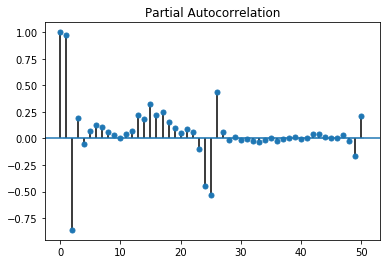

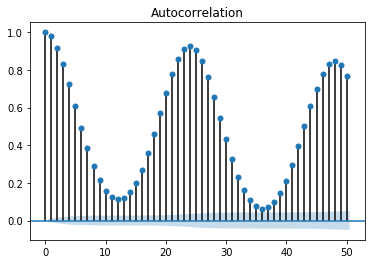

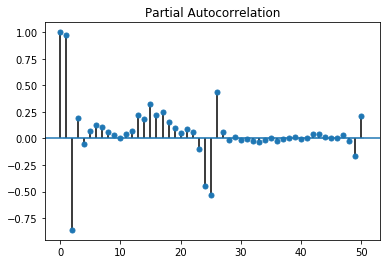

In [29]:
load = df['Load']
sm.graphics.tsa.plot_acf(load, lags = 50)
sm.graphics.tsa.plot_pacf(load, lags = 50)

In [30]:
# add feature: previous day's Load
df['lag24_Load'] = df['Load'].shift(24)

In [31]:
# add feature: previous one hour's Load
df['lag1_Load'] = df['Load'].shift(1)

In [32]:
# add feature: previous two hour's Load
df['lag2_Load'] = df['Load'].shift(2)

In [33]:
# add feature: previous 12 hour's Load
df['lag12_Load'] = df['Load'].shift(12)

In [34]:
# add feature: previous 7 day's Load
df['lag24/7_Load'] = df['Load'].shift(24*7)

In [35]:
# add feature: previous 15 hour's Load
df['lag15_Load'] = df['Load'].shift(15)

In [36]:
# add feature: previous 25 hour's Load
df['lag25_Load'] = df['Load'].shift(25)

#### drop features: year, day

In [37]:
df_temp = df.drop(['year','day'], axis = 1)
df_temp.dropna(inplace = True)

In [38]:
df_temp.head()

,Load,temp,month,datehour,temp2,day of week,weekday & weekend,quarter,week & period,temp & hour,...,temp2_nov,temp2_dec,Holiday,lag24_Load,lag1_Load,lag2_Load,lag12_Load,lag24/7_Load,lag15_Load,lag25_Load
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-08 00:00:00,9531.0,64.0373,1,0,4100.775791,2,1,1,weekday late night,0.0000,...,1,0,0,9351.0,10180.0,11156.0,11968.0,9891.0,11860.0,9995.0
2014-01-08 01:00:00,9261.0,61.1816,1,1,3743.188179,2,1,1,weekday late night,61.1816,...,1,0,0,9008.0,9531.0,10180.0,11954.0,9553.0,11950.0,9351.0
2014-01-08 02:00:00,9143.0,58.5185,1,2,3424.414842,2,1,1,weekday midnight,117.0370,...,1,1,0,8815.0,9261.0,9531.0,11885.0,9222.0,11998.0,9008.0
2014-01-08 03:00:00,9097.0,57.7022,1,3,3329.543885,2,1,1,weekday midnight,173.1066,...,1,1,0,8755.0,9143.0,9261.0,11848.0,9024.0,11968.0,8815.0
2014-01-08 04:00:00,9184.0,57.3026,1,4,3283.587967,2,1,1,weekday midnight,229.2104,...,1,1,0,8990.0,9097.0,9143.0,12103.0,8987.0,11954.0,8755.0


In [39]:
df_temp.columns

Index(['Load', 'temp', 'month', 'datehour', 'temp2', 'day of week',
       'weekday & weekend', 'quarter', 'week & period', 'temp & hour',
       'temp2 & hour', 'temp_h', 'temp & month', 'temp2 & month', 'temp_m',
       'temp_jan', 'temp_feb', 'temp_mar', 'temp_apr', 'temp_may', 'temp_jun',
       'temp_jul', 'temp_aug', 'temp_sep', 'temp_oct', 'temp_nov', 'temp_dec',
       'temp2_jan', 'temp2_feb', 'temp2_mar', 'temp2_apr', 'temp2_may',
       'temp2_jun', 'temp2_jul', 'temp2_aug', 'temp2_sep', 'temp2_oct',
       'temp2_nov', 'temp2_dec', 'Holiday', 'lag24_Load', 'lag1_Load',
       'lag2_Load', 'lag12_Load', 'lag24/7_Load', 'lag15_Load', 'lag25_Load'],
      dtype='object')

In [40]:
df_temp['month'] = df['month'].astype(str)
df_temp['datehour'] = df['datehour'].astype(str)
df_temp['day of week'] = df['day of week'].astype(str)

In [41]:
df1 = pd.get_dummies(df_temp,columns = ['weekday & weekend','quarter','month','temp_m','temp_h','datehour','week & period','day of week','Holiday',
                                       'temp_jan','temp_feb','temp_mar','temp_apr','temp_may','temp_jun','temp_jul','temp_aug',
                                        'temp_sep','temp_oct','temp_nov','temp_dec','temp2_jan','temp2_feb','temp2_mar',
                                        'temp2_apr','temp2_may','temp2_jun','temp2_jul','temp2_aug','temp2_sep',
                                        'temp2_oct','temp2_nov','temp2_dec'], drop_first = True)
df1.head()

,Load,temp,temp2,temp & hour,temp2 & hour,temp & month,temp2 & month,lag24_Load,lag1_Load,lag2_Load,...,temp2_mar_1,temp2_apr_1,temp2_may_1,temp2_jun_1,temp2_jul_1,temp2_aug_1,temp2_sep_1,temp2_oct_1,temp2_nov_1,temp2_dec_1
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-08 00:00:00,9531.0,64.0373,4100.775791,0.0000,0.000000,64.0373,4100.775791,9351.0,10180.0,11156.0,...,1,1,1,1,1,1,1,1,1,0
2014-01-08 01:00:00,9261.0,61.1816,3743.188179,61.1816,3743.188179,61.1816,3743.188179,9008.0,9531.0,10180.0,...,1,1,1,1,0,0,1,1,1,0
2014-01-08 02:00:00,9143.0,58.5185,3424.414842,117.0370,6848.829685,58.5185,3424.414842,8815.0,9261.0,9531.0,...,1,1,1,1,0,0,1,1,1,1
2014-01-08 03:00:00,9097.0,57.7022,3329.543885,173.1066,9988.631655,57.7022,3329.543885,8755.0,9143.0,9261.0,...,1,1,1,0,0,0,1,1,1,1
2014-01-08 04:00:00,9184.0,57.3026,3283.587967,229.2104,13134.351867,57.3026,3283.587967,8990.0,9097.0,9143.0,...,1,1,1,0,0,0,1,1,1,1


In [42]:
# show all features
cols = df1.columns.tolist()
cols

['Load',
 'temp',
 'temp2',
 'temp & hour',
 'temp2 & hour',
 'temp & month',
 'temp2 & month',
 'lag24_Load',
 'lag1_Load',
 'lag2_Load',
 'lag12_Load',
 'lag24/7_Load',
 'lag15_Load',
 'lag25_Load',
 'weekday & weekend_2',
 'quarter_2',
 'quarter_3',
 'quarter_4',
 'month_10',
 'month_11',
 'month_12',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'temp_m_2',
 'temp_m_3',
 'temp_m_5',
 'temp_m_6',
 'temp_m_7',
 'temp_m_8',
 'temp_m_other',
 'temp_h_temp2',
 'temp_h_temp3',
 'datehour_1',
 'datehour_10',
 'datehour_11',
 'datehour_12',
 'datehour_13',
 'datehour_14',
 'datehour_15',
 'datehour_16',
 'datehour_17',
 'datehour_18',
 'datehour_19',
 'datehour_2',
 'datehour_20',
 'datehour_21',
 'datehour_22',
 'datehour_23',
 'datehour_3',
 'datehour_4',
 'datehour_5',
 'datehour_6',
 'datehour_7',
 'datehour_8',
 'datehour_9',
 'week & period_ weekend midnight',
 'week & period_weekday early morning',
 'week & period_weekday late night

In [43]:
y = df1['Load']
X = df1.iloc[:,1:]

#### number of features

In [44]:
num_col = X.shape[1]
num_col

102

## Run Model

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

## VALIDATION

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

### Feature Scaling

In [47]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Linear Regression

In [48]:
m1 = LinearRegression().fit(X_train, y_train)
y_pred1 = m1.predict(X_test)
y_pred1

array([11478.85136218, 13019.26093785, 11720.40855506, ...,
       13642.32428955, 11455.88766598, 12787.5704116 ])

In [49]:
# MAE
mae1 = mean_absolute_error(y_test, y_pred1)
mae1

111.09961329335606

In [50]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(y_test, y_pred1)

0.9397214604115557

In [51]:
# R-SQUARE
r2_score(y_test, y_pred1)

0.9965022094150362

### Ridge

In [52]:
# tuning hyperparameter
parameters = {
    'alpha': [1e-15,1e-10,1e-5,0.1,0.2,0.3,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1,1.5,2,5,10]
}
Grid_ridge = GridSearchCV(Ridge(),parameters, cv=5)
Grid_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-05, 0.1, 0.2, 0.3, 0.4,
                                   0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 1, 1.5,
                                   2, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [53]:
best_ridge = Grid_ridge.best_params_
best_ridge

{'alpha': 0.45}

In [54]:
ridge = Ridge(alpha = best_ridge['alpha'])
m2 = ridge.fit(X_train, y_train) 
y_pred2 = m2.predict(X_test)
y_pred2

array([11478.95992126, 13018.58780393, 11719.74925379, ...,
       13641.77459913, 11456.00955452, 12787.48164206])

In [55]:
# MAE
mae2 = mean_absolute_error(y_test, y_pred2)
mae2

111.11110308498994

In [56]:
# MAPE
mean_absolute_percentage_error(y_test, y_pred2)

0.9398248765951266

In [57]:
# R-SQUARE
r2_score(y_test, y_pred2)

0.9965022055959905

### Lasso

In [58]:
# tuning hyperparameter
parameters = {
    'alpha': [1e-15,1e-5,0.005,0.03,0.05,0.1,0.5,1,10,100]
}
Grid_lasso = GridSearchCV(Lasso(),parameters, cv=5)
Grid_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-05, 0.005, 0.03, 0.05, 0.1, 0.5, 1,
                                   10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [59]:
best_lasso = Grid_lasso.best_params_
best_lasso

{'alpha': 0.1}

In [60]:
lasso = Lasso(alpha = best_lasso['alpha'])
m3 = lasso.fit(X_train,y_train)
y_pred3 = m3.predict(X_test)
y_pred3

array([11480.37850971, 13019.2715171 , 11716.83163442, ...,
       13648.04914908, 11459.41056441, 12794.34319929])

In [61]:
# MAE 
mae3 = mean_absolute_error(y_test, y_pred3)
mae3

111.11532523062462

In [62]:
# MAPE
mean_absolute_percentage_error(y_test, y_pred3)

0.9397206830318823

In [63]:
# R SQUARE
r2_score(y_test, y_pred3)

0.9965002380467157

##  CROSS VALIDATION

In [64]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [65]:
kfold = KFold(n_splits = 6,random_state = 1)
measure_mae = 'neg_mean_absolute_error' 

### cross validation in linear regression

In [66]:
# MAE
scores_mae1 = cross_val_score(LinearRegression(),X,y,cv = kfold,scoring = measure_mae)
mae_cv1 = -scores_mae1.mean()
mae_cv1

111.19913589578339

### cross validation in ridge regression

In [67]:
# MAE
scores_mae2 = cross_val_score(Ridge(alpha = best_ridge['alpha']),X,y,cv = kfold,scoring = measure_mae)
mae_cv2 = -scores_mae2.mean()
mae_cv2

111.18914423721668

### cross validation in lasso regression

In [68]:
# MAE
scores_mae3 = cross_val_score(Lasso(alpha = best_lasso['alpha']),X,y,cv = kfold,scoring = measure_mae)
mae_cv3 = -scores_mae3.mean()
mae_cv3

110.9974804251188

## TEST FEATURE IMPORTANCE

In [69]:
forest = RandomForestRegressor(random_state=1)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
sorted_importance = sorted(zip(map(lambda x: round(x, 4), importances), X.columns), reverse=True)

In [70]:
# print top 28 important features ranking by random forest
for k,v in sorted_importance[:28]:
    print (v + ": " + str(k))

lag1_Load: 0.9537
temp_h_temp3: 0.0146
lag24_Load: 0.0095
lag24/7_Load: 0.0042
temp & hour: 0.0033
lag2_Load: 0.0031
lag15_Load: 0.0025
week & period_weekday late night: 0.0018
temp_h_temp2: 0.0011
lag25_Load: 0.001
lag12_Load: 0.0008
temp2 & hour: 0.0005
weekday & weekend_2: 0.0003
week & period_weekday night: 0.0003
datehour_6: 0.0003
week & period_weekend late night: 0.0002
temp2 & month: 0.0002
temp2: 0.0002
temp & month: 0.0002
temp: 0.0002
datehour_5: 0.0002
datehour_17: 0.0002
week & period_weekend night: 0.0001
week & period_ weekend midnight: 0.0001
quarter_2: 0.0001
datehour_23: 0.0001
datehour_21: 0.0001
datehour_18: 0.0001


In [71]:
# the lag1 hour feature is extremly important

In [72]:
# select above features from feature dataframe
X_selected = []
for i in range(28):
    X_selected.append(sorted_importance[i][1])
X_selected
X_SF = X[X_selected]   
X_SF.head()

,lag1_Load,temp_h_temp3,lag24_Load,lag24/7_Load,temp & hour,lag2_Load,lag15_Load,week & period_weekday late night,temp_h_temp2,lag25_Load,...,temp & month,temp,datehour_5,datehour_17,week & period_weekend night,week & period_ weekend midnight,quarter_2,datehour_23,datehour_21,datehour_18
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-08 00:00:00,10180.0,1,9351.0,9891.0,0.0000,11156.0,11860.0,1,0,9995.0,...,64.0373,64.0373,0,0,0,0,0,0,0,0
2014-01-08 01:00:00,9531.0,1,9008.0,9553.0,61.1816,10180.0,11950.0,1,0,9351.0,...,61.1816,61.1816,0,0,0,0,0,0,0,0
2014-01-08 02:00:00,9261.0,1,8815.0,9222.0,117.0370,9531.0,11998.0,0,0,9008.0,...,58.5185,58.5185,0,0,0,0,0,0,0,0
2014-01-08 03:00:00,9143.0,1,8755.0,9024.0,173.1066,9261.0,11968.0,0,0,8815.0,...,57.7022,57.7022,0,0,0,0,0,0,0,0
2014-01-08 04:00:00,9097.0,0,8990.0,8987.0,229.2104,9143.0,11954.0,0,0,8755.0,...,57.3026,57.3026,0,0,0,0,0,0,0,0
